# Notebook Colab: Detección y Clasificación Bicicleta vs Auto (YOLOv8)

**Autor:** Generado automáticamente.

Este cuaderno implementa un flujo completo para entrenar, evaluar e inferir un modelo YOLOv8 que detecta bicicletas y autos usando datasets en formato YOLO v8 dentro de `Z_ProyectoYolo/datasets`.

---
## Índice de Secciones
0. Setup
1. Definición y justificación
2. Verificación de dataset
3. Visualización de datos y comprobaciones
4. Preparación de `data.yaml`
5. Selección del modelo y justificación
6. Entrenamiento
7. Visualización de logs y métricas
8. Evaluación cuantitativa
9. Inferencia (solo imágenes)
10. Empaquetado y entrega
11. Informe final (markdown y opcional PDF)
12. Checklist final

Ejecute cada sección en orden. Todo el contenido está en español y las rutas son relativas para reproducibilidad en Google Colab.


## 0. Setup

Instala dependencias, detecta Colab y prepara variables y carpetas del proyecto. Las rutas son relativas a `PROJECT_ROOT = 'Z_ProyectoYolo'`.

- Dependencias: `ultralytics`, `opencv-python-headless`, `matplotlib`, `pandas`, `tqdm`, `scikit-learn`, `seaborn`, `pyyaml`.
- Opción de montar Google Drive en Colab (desactivado por defecto; active `DO_MOUNT_DRIVE=True` si desea guardar en Drive).
- Fijación de semillas para reproducibilidad.
- Selección automática de dispositivo.
- Creación de carpetas de salida si no existen.
- Muestra versiones de `ultralytics` y `torch`.


In [5]:
# Instalación de dependencias y configuración inicial
# Nota: Pensado para Colab y ejecución local (PC). Evita instalar paquetes pesados innecesarios.

import os, sys, json, random, shutil, time, glob
from pathlib import Path

# Detectar si estamos en Google Colab
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# Flags de comportamiento
DO_MOUNT_DRIVE = False  # En Colab, montará Drive si True
SKIP_INSTALL = False    # En local, puede dejar True para no usar pip
WRITE_FREEZE_REQUIREMENTS = False  # Evitar escribir freeze pesado por defecto

# Utilidad: verificar si paquete está instalado
def is_installed(module_name: str) -> bool:
    try:
        __import__(module_name)
        return True
    except Exception:
        return False

# Paquetes requeridos (módulo -> paquete pip si difiere)
REQUIRED = {
    'ultralytics': 'ultralytics',
    'cv2': 'opencv-python-headless',
    'matplotlib': 'matplotlib',
    'pandas': 'pandas',
    'tqdm': 'tqdm',
    'sklearn': 'scikit-learn',
    'seaborn': 'seaborn',
    'yaml': 'pyyaml',
    'PIL': 'Pillow',
}

# (Opcional) Montar Drive en Colab
if IN_COLAB and DO_MOUNT_DRIVE:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=True)

# Establecer PROJECT_ROOT sin duplicar subcarpeta
# Si el repositorio ya está clonado y este notebook vive en la raíz del proyecto, usar '.'
PROJECT_ROOT = '.'  # raíz actual del notebook
PROJECT_NAME = 'Z_ProyectoYolo'  # para etiquetas y checklist

# Si estamos en Colab y existe una carpeta con el nombre del proyecto, cambiar cwd a ella
if IN_COLAB and Path(PROJECT_NAME).exists():
    PROJECT_ROOT = PROJECT_NAME
    os.chdir(PROJECT_ROOT)

DATASET_ROOT = os.path.join(PROJECT_ROOT, 'datasets')

# Directorios de salida (relativos a PROJECT_ROOT, no anidados doble)
RUNS_DIR = os.path.join(PROJECT_ROOT, 'runs')
EVAL_DIR = os.path.join(PROJECT_ROOT, 'evaluation')
EVAL_METRICS_DIR = os.path.join(EVAL_DIR, 'metrics')
EVAL_FIG_DIR = os.path.join(EVAL_DIR, 'figures')
INFER_DIR = os.path.join(PROJECT_ROOT, 'inference')
INFER_RESULTS_DIR = os.path.join(INFER_DIR, 'results_images')
INFER_NEW_IMG_DIR = os.path.join(INFER_DIR, 'images_new')
ENTREGA_DIR = os.path.join(PROJECT_ROOT, 'entrega_final')
ENTREGA_MODEL_DIR = os.path.join(ENTREGA_DIR, 'modelo')
DOCS_DIR = os.path.join(PROJECT_ROOT, 'docs')

# Crear carpetas requeridas
for d in [RUNS_DIR, EVAL_METRICS_DIR, EVAL_FIG_DIR, INFER_RESULTS_DIR, INFER_NEW_IMG_DIR, ENTREGA_MODEL_DIR, DOCS_DIR]:
    Path(d).mkdir(parents=True, exist_ok=True)

# Instalación condicional: solo instalar lo que falte
missing = [pip for mod, pip in REQUIRED.items() if not is_installed(mod)]
if missing and not SKIP_INSTALL:
    if IN_COLAB:
        %pip -q install {" ".join(missing)}
    else:
        import subprocess
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', *missing])
        except Exception as e:
            print('Aviso: no se pudieron instalar algunos paquetes:', e)
else:
    print('Sin instalaciones: todos los paquetes requeridos están presentes o SKIP_INSTALL=True')

import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fijar semillas para reproducibilidad
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
try:
    import torch
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except Exception:
    pass

# Seleccionar dispositivo (evita instalar CUDA explícitamente)
try:
    import torch
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
except Exception:
    DEVICE = 'cpu'

from importlib.metadata import version, PackageNotFoundError

def _ver(pkg):
    try:
        return version(pkg)
    except PackageNotFoundError:
        return 'no-instalado'

ultra_ver = _ver('ultralytics')
torch_ver = _ver('torch')
print(f"IN_COLAB={IN_COLAB} | DEVICE={DEVICE}")
print(f"ultralytics=={ultra_ver} | torch=={torch_ver}")
print(f"PROJECT_ROOT real: {Path(PROJECT_ROOT).resolve()}")

# Guardar requirements.txt (freeze) solo si se desea
req_path = os.path.join(PROJECT_ROOT, 'requirements.txt')
if WRITE_FREEZE_REQUIREMENTS:
    try:
        import subprocess
        freeze = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'], text=True)
        with open(req_path, 'w') as f:
            f.write(freeze)
        print(f"Guardado {req_path} con versiones instaladas.")
    except Exception as e:
        print('Aviso: no se pudo escribir requirements.txt:', e)
else:
    print('WRITE_FREEZE_REQUIREMENTS=False (se conserva requirements.txt minimal).')


Sin instalaciones: todos los paquetes requeridos están presentes o SKIP_INSTALL=True
IN_COLAB=False | DEVICE=cpu
ultralytics==8.3.193 | torch==2.8.0
PROJECT_ROOT real: /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo
WRITE_FREEZE_REQUIREMENTS=False (se conserva requirements.txt minimal).


## 1. Definición y justificación

**Objetivo:** Entrenar y evaluar un detector YOLOv8 capaz de detectar y clasificar objetos de las clases bicicleta y auto en imágenes.

**Justificación (usabilidad):**
- Conteo de tráfico y análisis de movilidad urbana.
- Seguridad vial y monitoreo de zonas con alta circulación.
- Gestión de estacionamientos y control de acceso en recintos.
- Apoyo a ciudades inteligentes para planificación de infraestructura.


## 2. Verificación de dataset

Validación de estructura, conteo de imágenes por split/clase y detección de inconsistencias. Se generan resúmenes en `evaluation/metrics/` y notas en `docs/labeling_notes.md`.


## 2. Unificación de datasets Roboflow (bicicleta vs auto)


Unifica los datasets de Roboflow `bicycle.v1i.yolov8` (solo clase bicycle) y `Car.v5-car_4.yolov8` (solo clase car) en un dataset binario `datasets/merged_bike_car/` con etiquetas remapeadas:


- 0 → bicicleta


- 1 → auto




Se crean enlaces simbólicos a las imágenes originales cuando es posible (y copias si no), evitando duplicar datos.

In [6]:
# Verificación de la estructura del dataset y conteos
from collections import Counter, defaultdict
import pandas as pd

required_dirs = [
    os.path.join(DATASET_ROOT, 'images', 'train'),
    os.path.join(DATASET_ROOT, 'images', 'val'),
    os.path.join(DATASET_ROOT, 'labels', 'train'),
    os.path.join(DATASET_ROOT, 'labels', 'val'),
]

missing_reqs = [d for d in required_dirs if not Path(d).exists()]
if missing_reqs:
    print("ADVERTENCIA: Faltan directorios requeridos:")
    for d in missing_reqs:
        print(" -", d)
else:
    print("Estructura mínima encontrada.")

IMG_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}

split_stats = {}
label_issues = { 'missing_label_for_image': [], 'empty_label_file': [], 'malformed_lines': [] }
class_counts = { 'train': Counter(), 'val': Counter() }
image_counts = { 'train': 0, 'val': 0 }
instance_counts = { 'train': 0, 'val': 0 }

for split in ['train','val']:
    img_dir = os.path.join(DATASET_ROOT, 'images', split)
    lab_dir = os.path.join(DATASET_ROOT, 'labels', split)
    imgs = []
    if Path(img_dir).exists():
        for p in Path(img_dir).glob('*'):
            if p.suffix.lower() in IMG_EXT:
                imgs.append(p)
    image_counts[split] = len(imgs)

    # Verificar que cada imagen tenga su .txt correspondiente
    for img_path in imgs:
        label_path = Path(lab_dir) / (img_path.stem + '.txt')
        if not label_path.exists():
            label_issues['missing_label_for_image'].append(str(img_path))
            continue
        # Leer archivo de etiquetas
        try:
            with open(label_path, 'r') as f:
                lines = [ln.strip() for ln in f.readlines() if ln.strip()]
        except Exception as e:
            label_issues['malformed_lines'].append(f"{label_path} :: error apertura {e}")
            continue
        if len(lines) == 0:
            label_issues['empty_label_file'].append(str(label_path))
        for ln in lines:
            parts = ln.split()
            if len(parts) != 5:
                label_issues['malformed_lines'].append(f"{label_path} :: '{ln}'")
                continue
            try:
                cls_id = int(float(parts[0]))
                # YOLOv8 usa: class cx cy w h (normalizados)
                _ = [float(x) for x in parts[1:]]
                if cls_id not in [0,1]:
                    label_issues['malformed_lines'].append(f"{label_path} :: clase inválida {cls_id}")
                    continue
                class_counts[split][cls_id] += 1
                instance_counts[split] += 1
            except Exception:
                label_issues['malformed_lines'].append(f"{label_path} :: '{ln}' (parse)")

# Resumen por split
summary_rows = []
for split in ['train','val']:
    row = {
        'split': split,
        'images': image_counts[split],
        'instances_total': instance_counts[split],
        'instances_bicicleta(cls0)': class_counts[split][0],
        'instances_auto(cls1)': class_counts[split][1],
    }
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
summary_df

# Guardar resumen
summary_csv = os.path.join(EVAL_METRICS_DIR, 'dataset_summary.csv')
summary_json = os.path.join(EVAL_METRICS_DIR, 'dataset_summary.json')
summary_df.to_csv(summary_csv, index=False)
with open(summary_json, 'w') as f:
    json.dump({
        'images': image_counts,
        'instances': instance_counts,
        'class_counts': {k: dict(v) for k,v in class_counts.items()},
        'issues_counts': {k: len(v) for k,v in label_issues.items()}
    }, f, indent=2)
print('Guardado resumen en:', summary_csv, 'y', summary_json)

# Guardar notas de etiquetado
label_notes = os.path.join(DOCS_DIR, 'labeling_notes.md')
with open(label_notes, 'a') as f:
    f.write('\n\n## Verificación automática\n')
    f.write(f"\nFecha: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
    if label_issues['missing_label_for_image']:
        f.write('\n### Imágenes sin archivo de etiqueta (.txt)\n')
        for p in label_issues['missing_label_for_image']:
            f.write(f"- {p}\n")
    if label_issues['empty_label_file']:
        f.write('\n### Archivos de etiqueta vacíos\n')
        for p in label_issues['empty_label_file']:
            f.write(f"- {p}\n")
    if label_issues['malformed_lines']:
        f.write('\n### Líneas mal formateadas\n')
        for desc in label_issues['malformed_lines']:
            f.write(f"- {desc}\n")

# Advertencia por desbalance o escasez (<50 instancias por clase)
for split in ['train','val']:
    for cls_id, cls_name in [(0,'bicicleta'),(1,'auto')]:
        if class_counts[split][cls_id] < 50:
            print(f"ADVERTENCIA: Clase '{cls_name}' en split '{split}' tiene menos de 50 instancias ({class_counts[split][cls_id]}). Considere aumentar los datos.")

# Mensaje de balance
def _imbalance_msg(cc):
    total = cc[0] + cc[1]
    if total == 0:
        return 'sin instancias'
    ratio = (cc[0] / total) if total > 0 else 0
    return f"bicicleta={cc[0]} ({ratio:.1%}), auto={cc[1]} ({1-ratio:.1%})"

print('Distribución train:', _imbalance_msg(class_counts['train']))
print('Distribución val  :', _imbalance_msg(class_counts['val']))


ADVERTENCIA: Faltan directorios requeridos:
 - ./datasets/images/train
 - ./datasets/images/val
 - ./datasets/labels/train
 - ./datasets/labels/val
Guardado resumen en: ./evaluation/metrics/dataset_summary.csv y ./evaluation/metrics/dataset_summary.json
ADVERTENCIA: Clase 'bicicleta' en split 'train' tiene menos de 50 instancias (0). Considere aumentar los datos.
ADVERTENCIA: Clase 'auto' en split 'train' tiene menos de 50 instancias (0). Considere aumentar los datos.
ADVERTENCIA: Clase 'bicicleta' en split 'val' tiene menos de 50 instancias (0). Considere aumentar los datos.
ADVERTENCIA: Clase 'auto' en split 'val' tiene menos de 50 instancias (0). Considere aumentar los datos.
Distribución train: sin instancias
Distribución val  : sin instancias


In [7]:
# Unificar datasets Roboflow en uno binario bicicleta(0) vs auto(1)
import yaml
from pathlib import Path

SRC_BICYCLE_DIR = os.path.join(PROJECT_ROOT, 'datasets', 'bicycle.v1i.yolov8')
SRC_CAR_DIR = os.path.join(PROJECT_ROOT, 'datasets', 'Car.v5-car_4.yolov8')
MERGED_ROOT = os.path.join(PROJECT_ROOT, 'datasets', 'merged_bike_car')

# Leer índices de clase
idx_bicycle = None
idx_car = None
try:
    bike_cfg = yaml.safe_load(open(os.path.join(SRC_BICYCLE_DIR, 'data.yaml'), 'r'))
    idx_bicycle = bike_cfg['names'].index('bicycle') if 'names' in bike_cfg else 0
except Exception as e:
    print('Aviso bicycle:', e)
try:
    car_cfg = yaml.safe_load(open(os.path.join(SRC_CAR_DIR, 'data.yaml'), 'r'))
    idx_car = car_cfg['names'].index('car') if 'names' in car_cfg else 2
except Exception as e:
    print('Aviso car:', e)

print('Índices origen bicycle:', idx_bicycle, '| car:', idx_car)

for split in ['train','val']:
    Path(os.path.join(MERGED_ROOT, 'images', split)).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(MERGED_ROOT, 'labels', split)).mkdir(parents=True, exist_ok=True)

IMG_EXTS = {'.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp'}

def find_image(src_img_dir, stem):
    for ext in IMG_EXTS:
        p = Path(src_img_dir) / f"{stem}{ext}"
        if p.exists():
            return str(p)
    for p in Path(src_img_dir).glob(f"{stem}.*"):
        if p.suffix.lower() in IMG_EXTS:
            return str(p)
    return None

summary_counts = { 'train': {'bicicleta':0, 'auto':0}, 'val': {'bicicleta':0, 'auto':0} }

def process_dataset(src_root, wanted_cls_idx, target_cls_id, prefix, split_map):
    if wanted_cls_idx is None:
        print(f"Saltar {prefix}: índice clase no disponible")
        return
    for src_split, dst_split in split_map.items():
        src_lab_dir = os.path.join(src_root, src_split, 'labels')
        src_img_dir = os.path.join(src_root, src_split, 'images')
        dst_lab_dir = os.path.join(MERGED_ROOT, 'labels', dst_split)
        dst_img_dir = os.path.join(MERGED_ROOT, 'images', dst_split)
        if not Path(src_lab_dir).exists():
            continue
        for lab_path in Path(src_lab_dir).glob('*.txt'):
            try:
                lines = [ln.strip() for ln in open(lab_path).read().splitlines() if ln.strip()]
            except Exception as e:
                print('Error label', lab_path, e)
                continue
            new_lines = []
            for ln in lines:
                parts = ln.split()
                if len(parts) != 5:
                    continue
                try:
                    cls = int(float(parts[0]))
                except Exception:
                    continue
                if cls == wanted_cls_idx:
                    new_lines.append(f"{target_cls_id} {' '.join(parts[1:])}")
            if not new_lines:
                continue
            stem = lab_path.stem
            src_img = find_image(src_img_dir, stem)
            if not src_img:
                continue
            src_img_path = Path(src_img)
            dst_img_name = f"{prefix}_{src_img_path.name}"
            dst_img_path = Path(dst_img_dir) / dst_img_name
            if not dst_img_path.exists():
                try:
                    os.symlink(src_img_path.resolve(), dst_img_path)
                except Exception:
                    shutil.copy2(str(src_img_path), str(dst_img_path))
            dst_lab_path = Path(dst_lab_dir) / (Path(dst_img_name).stem + '.txt')
            with open(dst_lab_path, 'w') as f:
                f.write('\n'.join(new_lines) + '\n')
            if target_cls_id == 0:
                summary_counts[dst_split]['bicicleta'] += len(new_lines)
            else:
                summary_counts[dst_split]['auto'] += len(new_lines)

split_mapping_bike = {'train':'train', 'valid':'val', 'val':'val'}
split_mapping_car  = {'train':'train', 'valid':'val', 'val':'val'}
process_dataset(SRC_BICYCLE_DIR, idx_bicycle, 0, 'bicycle', split_mapping_bike)
process_dataset(SRC_CAR_DIR, idx_car, 1, 'car', split_mapping_car)

print('Resumen instancias remapeadas:')
for sp in ['train','val']:
    print(sp, '->', summary_counts[sp])

# Actualizar DATASET_ROOT para posteriores celdas
DATASET_ROOT = MERGED_ROOT
print('DATASET_ROOT ahora:', DATASET_ROOT)


Índices origen bicycle: 0 | car: 2
Resumen instancias remapeadas:
train -> {'bicicleta': 480, 'auto': 106}
val -> {'bicicleta': 51, 'auto': 41}
DATASET_ROOT ahora: ./datasets/merged_bike_car
Resumen instancias remapeadas:
train -> {'bicicleta': 480, 'auto': 106}
val -> {'bicicleta': 51, 'auto': 41}
DATASET_ROOT ahora: ./datasets/merged_bike_car


## 3. Visualización de datos y comprobaciones

Se muestran 8–12 ejemplos aleatorios del split de entrenamiento con bounding boxes dibujados a partir de los archivos de etiqueta YOLO (`class cx cy w h`). La figura se guarda en `evaluation/figures/sample_grid.png`.


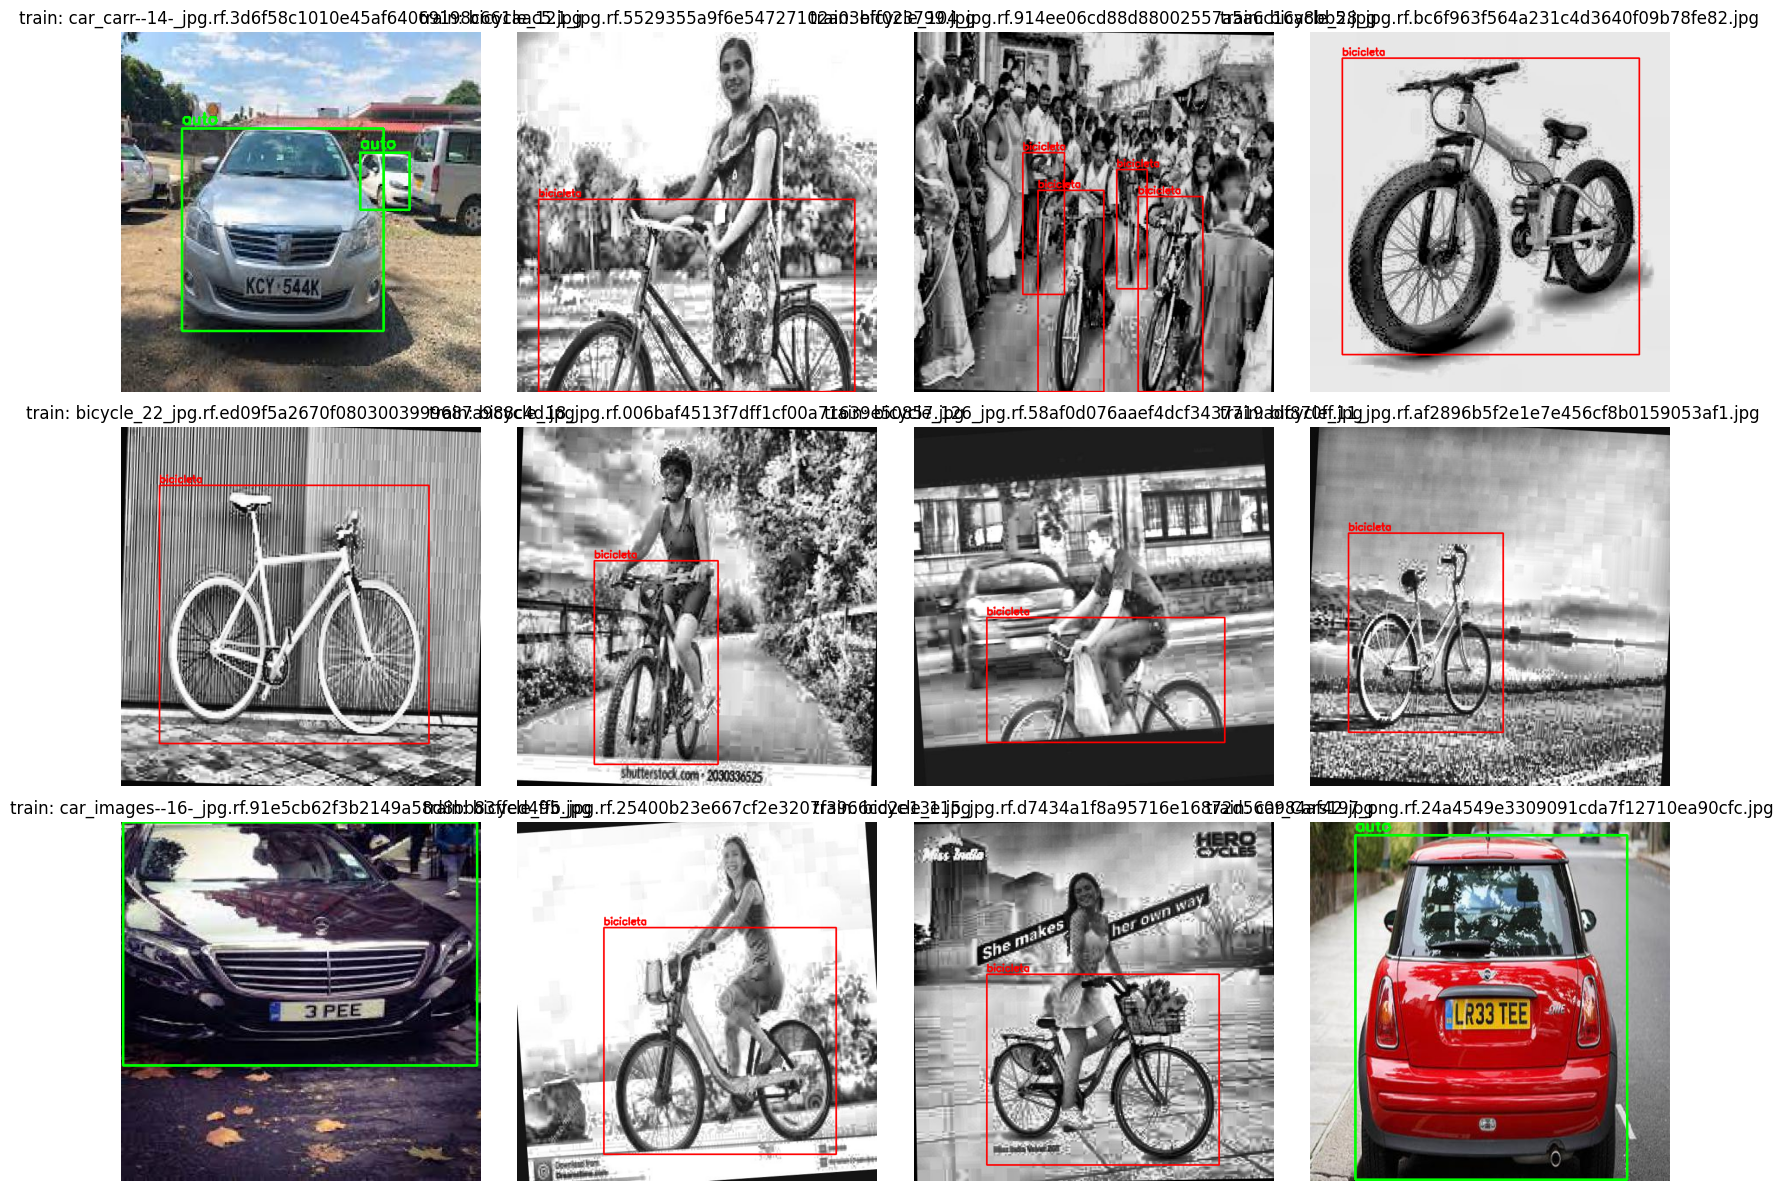

Guardada figura de ejemplos en: ./evaluation/figures/sample_grid.png (split usado: train)


In [8]:
# Visualización aleatoria de ejemplos etiquetados del split train (con tolerancia a vacíos)
import math

# Recolectar imágenes del split de entrenamiento; si no hay, usar val como fallback
train_img_dir = os.path.join(DATASET_ROOT, 'images', 'train')
train_lab_dir = os.path.join(DATASET_ROOT, 'labels', 'train')
val_img_dir = os.path.join(DATASET_ROOT, 'images', 'val')
val_lab_dir = os.path.join(DATASET_ROOT, 'labels', 'val')

all_train_imgs = [p for p in Path(train_img_dir).glob('*') if p.suffix.lower() in IMG_EXT] if Path(train_img_dir).exists() else []
use_split = 'train'
img_dir = train_img_dir
lab_dir = train_lab_dir
img_list = all_train_imgs

if len(all_train_imgs) == 0:
    # Fallback a val si no hay imágenes en train
    all_val_imgs = [p for p in Path(val_img_dir).glob('*') if p.suffix.lower() in IMG_EXT] if Path(val_img_dir).exists() else []
    img_list = all_val_imgs
    img_dir = val_img_dir
    lab_dir = val_lab_dir
    use_split = 'val'

if len(img_list) == 0:
    print('No se encontraron imágenes en train ni en val. Se omite la visualización de ejemplos.')
else:
    n_total = len(img_list)
    n_show = min(12, n_total)
    # Selección aleatoria segura
    sel = random.sample(img_list, n_show) if n_total >= n_show else img_list[:n_show]

    class_names = {0: 'bicicleta', 1: 'auto'}
    fig_cols = 4
    fig_rows = max(1, math.ceil(len(sel)/fig_cols))
    plt.figure(figsize=(16, 4*fig_rows))

    missing_label_imgs = []

    for i, img_path in enumerate(sel, 1):
        lab_path = Path(lab_dir) / (img_path.stem + '.txt')
        img = cv2.imread(str(img_path))
        if img is None:
            # Imagen ilegible: continuar
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H, W = img.shape[:2]
        boxes = []
        if not lab_path.exists():
            missing_label_imgs.append(str(img_path))
        else:
            with open(lab_path, 'r') as f:
                lines = [ln.strip() for ln in f.readlines() if ln.strip()]
            for ln in lines:
                parts = ln.split()
                if len(parts) != 5:
                    continue
                try:
                    cls_id = int(float(parts[0]))
                    cx, cy, w, h = map(float, parts[1:])
                    # Convertir normalizados a pixeles y recortar a límites de imagen
                    x1 = max(0, min(W-1, int((cx - w/2) * W)))
                    y1 = max(0, min(H-1, int((cy - h/2) * H)))
                    x2 = max(0, min(W-1, int((cx + w/2) * W)))
                    y2 = max(0, min(H-1, int((cy + h/2) * H)))
                    if x2 > x1 and y2 > y1 and cls_id in (0,1):
                        boxes.append((x1,y1,x2,y2,cls_id))
                except Exception:
                    continue
        # Dibujar
        img_draw = img.copy()
        for (x1,y1,x2,y2,cls_id) in boxes:
            color = (0,255,0) if cls_id == 1 else (255,0,0)
            cv2.rectangle(img_draw, (x1,y1), (x2,y2), color, 2)
            label = class_names.get(cls_id, f"cls{cls_id}")
            cv2.putText(img_draw, label, (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        plt.subplot(fig_rows, fig_cols, i)
        plt.imshow(img_draw)
        plt.axis('off')
        plt.title(f"{use_split}: {img_path.name}")

    plt.tight_layout()
    fig_path = os.path.join(EVAL_FIG_DIR, 'sample_grid.png')
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print(f"Guardada figura de ejemplos en: {fig_path} (split usado: {use_split})")

    # Registrar imágenes sin label en labeling_notes.md
    if missing_label_imgs:
        with open(os.path.join(DOCS_DIR, 'labeling_notes.md'), 'a') as f:
            f.write(f"\n### Imágenes sin label detectadas en visualización ({use_split})\n")
            for p in missing_label_imgs:
                f.write(f"- {p}\n")


## 4. Preparación de `data.yaml`

Se crea y valida el archivo de configuración con rutas relativas y nombres de clases.


In [9]:
# Crear/validar data.yaml con rutas relativas y clases (sin duplicar raíz)
DATA_YAML_PATH = os.path.join(PROJECT_ROOT, 'data.yaml')

# Usar dataset fusionado por defecto
MERGED_REL = 'datasets/merged_bike_car'
MERGED_IMG_TRAIN = os.path.join(MERGED_REL, 'images', 'train')
MERGED_IMG_VAL   = os.path.join(MERGED_REL, 'images', 'val')

# Si aún no existe el fusionado (antes de correr la celda de unificación), dejar igualmente apuntando al fusionado
# y advertir; la celda de unificación lo creará.
if not Path(os.path.join(PROJECT_ROOT, MERGED_IMG_TRAIN)).exists():
    print('ADVERTENCIA: Aún no existe el dataset fusionado. Ejecute la celda de "Unificar datasets" y vuelva a correr esta celda si es necesario.')

data_cfg = {
    'train': MERGED_IMG_TRAIN,
    'val':   MERGED_IMG_VAL,
    'nc': 2,
    'names': ['bicicleta','auto']
}

with open(DATA_YAML_PATH, 'w') as f:
    yaml.safe_dump(data_cfg, f, sort_keys=False, allow_unicode=True)

print('Escrito:', DATA_YAML_PATH)
print('Contenido:')
print(yaml.safe_dump(data_cfg, sort_keys=False, allow_unicode=True))

# Validar rutas (advertir si no existen)
req_paths = [
    os.path.join(PROJECT_ROOT, MERGED_REL, 'images', 'train'),
    os.path.join(PROJECT_ROOT, MERGED_REL, 'images', 'val'),
    os.path.join(PROJECT_ROOT, MERGED_REL, 'labels', 'train'),
    os.path.join(PROJECT_ROOT, MERGED_REL, 'labels', 'val'),
]
missing = [p for p in req_paths if not Path(p).exists()]
if missing:
    print('ADVERTENCIA: Faltan rutas esperadas del dataset fusionado YOLOv8:')
    for m in missing:
        print(' -', m)
    print('Ejecute la celda de unificación para generarlas.')
else:
    print('Validación básica de rutas OK.')


Escrito: ./data.yaml
Contenido:
train: datasets/merged_bike_car/images/train
val: datasets/merged_bike_car/images/val
nc: 2
names:
- bicicleta
- auto

Validación básica de rutas OK.


## 5. Selección del modelo y justificación

Se emplea `yolov8n.pt` (nano) por su ligereza y velocidad en CPU/GPU gratuitas. Esto mantiene el propósito: entrenar un detector binario bicicleta vs auto sin sobrecargar memoria.

Backbones alternativos (si se necesita más precisión y se dispone de GPU estable):
- `yolov8s.pt` (small) – mejor mAP, más coste computacional.
- `yolov8m.pt` o superiores: no recomendados en CPU o Colab Free para este caso.

Hiperparámetros son dinámicos según el dispositivo detectado:
- CPU (ej. 8GB RAM): `IMGSZ=512`, `EPOCHS=15`, `BATCH=4`.
- GPU disponible: `IMGSZ=640`, `EPOCHS=40`, `BATCH=16`.

Si aparece OOM (Out Of Memory), el flujo de entrenamiento reduce automáticamente el batch (16→8→4→2). Esto evita que tengas que reiniciar manualmente.

Aumentos (por defecto YOLOv8): mosaic, flip horizontal, cambios HSV, escala. Suficientes para este problema inicial.

Dataset: se usa el conjunto ya unificado en `datasets/merged_bike_car` (clases remapeadas 0: bicicleta, 1: auto).


In [11]:
# Entrenamiento con reintento ante OOM y normalización de rutas de salida
from ultralytics import YOLO

os.makedirs(RUNS_DIR, exist_ok=True)

# Mantener cwd en PROJECT_ROOT (ya es '.'); imprimir para transparencia
print('CWD for training:', os.getcwd())

cli_cmd = f"yolo detect train model={MODEL_BACKBONE} data=data.yaml imgsz={IMGSZ} epochs={EPOCHS} batch={BATCH} project=runs name=exp_bici_auto"
print('Comando reproducible CLI:\n', cli_cmd)

# Lista de batches para reintentos, descendente
candidates = sorted({BATCH, 8, 4, 2}, reverse=True)
train_success = False
train_save_dir = None
for b in candidates:
    try:
        print(f"\nIntentando entrenamiento con batch={b} ...")
        model = YOLO(MODEL_BACKBONE)
        results = model.train(
            data='data.yaml',
            imgsz=IMGSZ,
            epochs=EPOCHS,
            batch=b,
            project='runs',
            name='exp_bici_auto',
            verbose=True,
        )
        try:
            train_save_dir = str(model.trainer.save_dir)
        except Exception:
            train_save_dir = None
        train_success = True
        break
    except RuntimeError as e:
        if 'out of memory' in str(e).lower() or 'cuda out of memory' in str(e).lower():
            print('OOM detectado. Probando con batch menor...')
            continue
        else:
            raise e

if not train_success:
    raise RuntimeError('Entrenamiento falló en todos los tamaños de batch.')

# Normalizar ruta: asegurar runs/exp_bici_auto/weights/best.pt
norm_run_dir = os.path.join('runs', 'exp_bici_auto')
Path(norm_run_dir).mkdir(parents=True, exist_ok=True)

# Buscar best.pt en subcarpetas de runs
best_candidate = None
for p in Path('runs').rglob('best.pt'):
    if 'exp_bici_auto' in str(p):
        best_candidate = p
        break

if best_candidate is None:
    print('ADVERTENCIA: No se encontró best.pt. Verifique el entrenamiento.')
else:
    dest_dir = os.path.join('runs', 'exp_bici_auto', 'weights')
    Path(dest_dir).mkdir(parents=True, exist_ok=True)
    dest_path = os.path.join(dest_dir, 'best.pt')
    try:
        # Evitar copiar sobre el mismo archivo (causa SameFileError)
        same = False
        try:
            same = Path(best_candidate).resolve() == Path(dest_path).resolve()
        except Exception:
            # En algunos FS, resolve puede fallar; usar os.path.samefile si existe
            try:
                import os
                same = os.path.exists(dest_path) and os.path.samefile(str(best_candidate), dest_path)
            except Exception:
                same = False
        if same:
            print('best.pt ya está en la ruta normalizada:', dest_path)
        else:
            shutil.copy2(str(best_candidate), dest_path)
            print('best.pt normalizado a:', dest_path)
    except Exception as e:
        print('Aviso al normalizar best.pt:', e)


CWD for training: /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo
Comando reproducible CLI:
 yolo detect train model=yolov8n.pt data=data.yaml imgsz=512 epochs=10 batch=4 project=runs name=exp_bici_auto

Intentando entrenamiento con batch=8 ...
New https://pypi.org/project/ultralytics/8.3.227 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.193 🚀 Python-3.11.9 torch-2.8.0+cu128 CPU (AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx)
New https://pypi.org/project/ultralytics/8.3.227 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.193 🚀 Python-3.11.9 torch-2.8.0+cu128 CPU (AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, de

## 6. Entrenamiento

Comando reproducible (CLI):

```
# Desde la raíz del proyecto
# Usa el dataset fusionado (data.yaml ya apunta a datasets/merged_bike_car)
yolo detect train model=yolov8n.pt data=data.yaml imgsz=640 epochs=40 batch=16 project=runs name=exp_bici_auto
```

A continuación se ejecuta el entrenamiento con la API de Python. Si hay OOM, se reintenta con batch menor (16→8→4→2). Al finalizar, el modelo se normaliza a `runs/exp_bici_auto/weights/best.pt`. Esto evita confusiones con subcarpetas que Ultralytics pueda crear (por ejemplo, `runs/detect/...`).


In [12]:
# Entrenamiento con reintento ante OOM y normalización de rutas de salida
from ultralytics import YOLO

os.makedirs(RUNS_DIR, exist_ok=True)

# Mantener cwd en PROJECT_ROOT (ya es '.'); imprimir para transparencia
print('CWD for training:', os.getcwd())

cli_cmd = f"yolo detect train model={MODEL_BACKBONE} data=data.yaml imgsz={IMGSZ} epochs={EPOCHS} batch={BATCH} project=runs name=exp_bici_auto"
print('Comando reproducible CLI:\n', cli_cmd)

# Lista de batches para reintentos, descendente
candidates = sorted({BATCH, 8, 4, 2}, reverse=True)
train_success = False
train_save_dir = None
for b in candidates:
    try:
        print(f"\nIntentando entrenamiento con batch={b} ...")
        model = YOLO(MODEL_BACKBONE)
        results = model.train(
            data='data.yaml',
            imgsz=IMGSZ,
            epochs=EPOCHS,
            batch=b,
            project='runs',
            name='exp_bici_auto',
            verbose=True,
        )
        try:
            train_save_dir = str(model.trainer.save_dir)
        except Exception:
            train_save_dir = None
        train_success = True
        break
    except RuntimeError as e:
        if 'out of memory' in str(e).lower() or 'CUDA out of memory' in str(e):
            print('OOM detectado. Probando con batch menor...')
            continue
        else:
            raise e

if not train_success:
    raise RuntimeError('Entrenamiento falló en todos los tamaños de batch.')

# Normalizar ruta: asegurar runs/exp_bici_auto/weights/best.pt
norm_run_dir = os.path.join('runs', 'exp_bici_auto')
Path(norm_run_dir).mkdir(parents=True, exist_ok=True)

# Buscar best.pt en subcarpetas de runs
best_candidate = None
for p in Path('runs').rglob('best.pt'):
    if 'exp_bici_auto' in str(p):
        best_candidate = p
        break

if best_candidate is None:
    print('ADVERTENCIA: No se encontró best.pt. Verifique el entrenamiento.')
else:
    dest_dir = os.path.join('runs', 'exp_bici_auto', 'weights')
    Path(dest_dir).mkdir(parents=True, exist_ok=True)
    dest_path = os.path.join(dest_dir, 'best.pt')
    shutil.copy2(str(best_candidate), dest_path)
    print('best.pt normalizado a:', dest_path)


CWD for training: /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo
Comando reproducible CLI:
 yolo detect train model=yolov8n.pt data=data.yaml imgsz=512 epochs=10 batch=4 project=runs name=exp_bici_auto

Intentando entrenamiento con batch=8 ...
New https://pypi.org/project/ultralytics/8.3.227 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.193 🚀 Python-3.11.9 torch-2.8.0+cu128 CPU (AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx)
New https://pypi.org/project/ultralytics/8.3.227 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.193 🚀 Python-3.11.9 torch-2.8.0+cu128 CPU (AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, de

KeyboardInterrupt: 

## 7. Visualización de logs y métricas

Se extraen métricas de entrenamiento (losses, precisión, recall, mAP) y se generan gráficos guardados en `evaluation/figures/`.


results.csv: ./runs/exp_bici_auto/results.csv


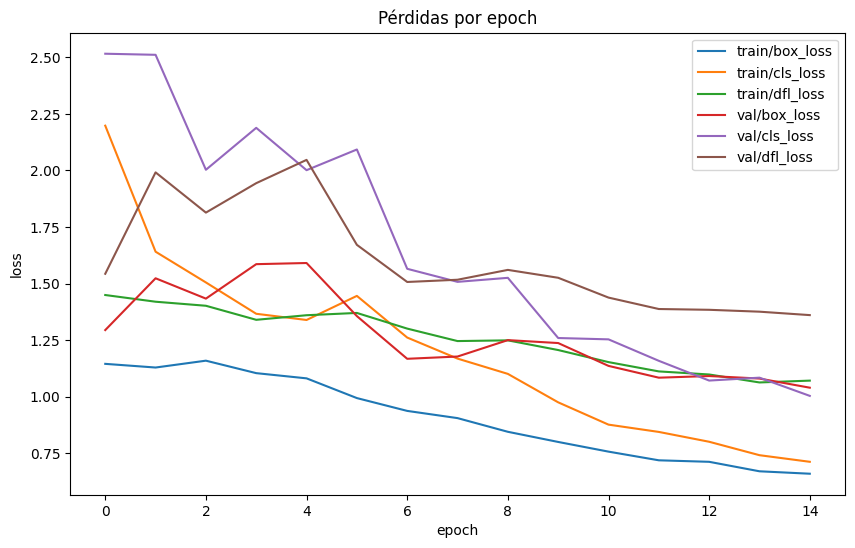

Guardado gráfico de pérdidas en: ./evaluation/figures/losses.png


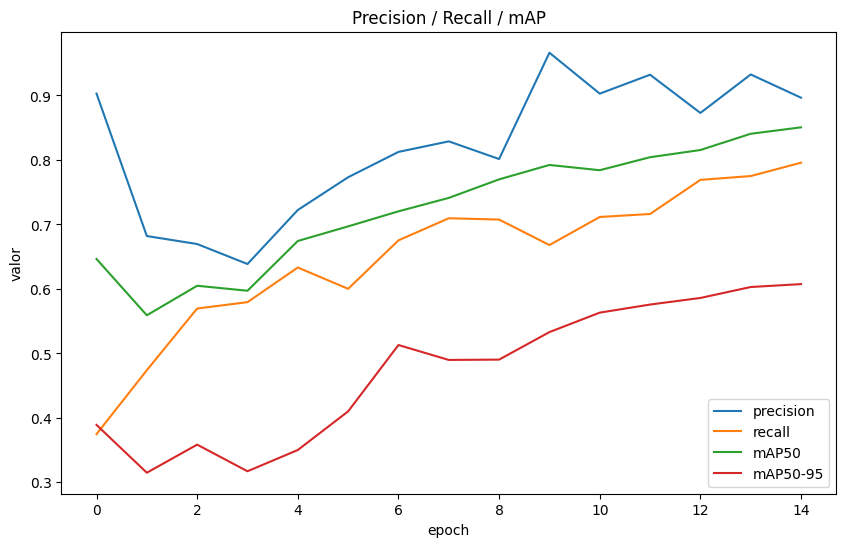

Guardado gráfico PR/mAP en: ./evaluation/figures/pr_map.png
Métricas consolidadas en: ./evaluation/metrics/metrics.json


In [13]:
# Cargar logs de entrenamiento y graficar métricas
import pandas as pd

# Intentar localizar el directorio del experimento
candidates = [
    os.path.join(PROJECT_ROOT, 'runs', 'exp_bici_auto'),
    os.path.join(PROJECT_ROOT, 'runs', 'detect', 'exp_bici_auto'),
]
run_dir = None
for c in candidates:
    if Path(c).exists():
        run_dir = c
        break

if run_dir is None:
    # Buscar por results.csv en runs
    for p in Path(os.path.join(PROJECT_ROOT, 'runs')).rglob('results.csv'):
        if 'exp_bici_auto' in str(p):
            run_dir = str(p.parent)
            break

if run_dir is None:
    raise FileNotFoundError('No se encontró el directorio de corrida con results.csv')

results_csv = os.path.join(run_dir, 'results.csv')
print('results.csv:', results_csv)
results = pd.read_csv(results_csv)

# Graficar pérdidas por epoch
loss_cols = [c for c in results.columns if 'loss' in c.lower()]
plt.figure(figsize=(10,6))
for col in loss_cols:
    plt.plot(results.index, results[col], label=col)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Pérdidas por epoch')
plt.legend()
loss_fig = os.path.join(EVAL_FIG_DIR, 'losses.png')
plt.savefig(loss_fig, dpi=150)
plt.show()
print('Guardado gráfico de pérdidas en:', loss_fig)

# Graficar Precision/Recall y mAP
metric_cols = {}
for key in ['precision', 'recall', 'mAP50', 'mAP50-95']:
    matches = [c for c in results.columns if key.lower() in c.lower()]
    if matches:
        metric_cols[key] = matches[0]

plt.figure(figsize=(10,6))
for key, col in metric_cols.items():
    plt.plot(results.index, results[col], label=key)
plt.xlabel('epoch')
plt.ylabel('valor')
plt.title('Precision / Recall / mAP')
plt.legend()
pr_fig = os.path.join(EVAL_FIG_DIR, 'pr_map.png')
plt.savefig(pr_fig, dpi=150)
plt.show()
print('Guardado gráfico PR/mAP en:', pr_fig)

# Consolidar métricas finales
final_metrics = {}
for key, col in metric_cols.items():
    final_metrics[key] = float(results[col].iloc[-1])

# Guardar en metrics.json (merge con dataset_summary)
metrics_json = os.path.join(EVAL_METRICS_DIR, 'metrics.json')
base = {}
if Path(metrics_json).exists():
    try:
        base = json.load(open(metrics_json, 'r'))
    except Exception:
        base = {}
base.update({'training': {
    'run_dir': run_dir,
    'final_metrics': final_metrics,
}})
with open(metrics_json, 'w') as f:
    json.dump(base, f, indent=2)
print('Métricas consolidadas en:', metrics_json)


## 8. Evaluación cuantitativa

Se ejecuta validación con el mejor modelo y se construye la matriz de confusión, consolidando métricas (Precision, Recall, mAP@0.5, mAP@0.5:0.95, IoU promedio). Fórmula del IoU:

$$IoU = \frac{|A \cap B|}{|A \cup B|}$$


In [ ]:
# Inferencia con best.pt sobre val y (opcional) imágenes nuevas
from ultralytics import YOLO
import math
from pathlib import Path

# Resolver best.pt de forma robusta
best_path = os.path.join(PROJECT_ROOT, 'runs', 'exp_bici_auto', 'weights', 'best.pt')
if not Path(best_path).exists():
    cand = None
    for p in Path(os.path.join(PROJECT_ROOT, 'runs')).rglob('best.pt'):
        # Preferir los que pertenezcan al experimento nombrado
        if 'exp_bici_auto' in str(p):
            cand = str(p)
            break
        elif cand is None:
            cand = str(p)
    best_path = cand if cand else best_path

if not (best_path and Path(best_path).exists()):
    print('ADVERTENCIA: No se encontró best.pt. Ejecute el entrenamiento antes de esta celda.')
else:
    print('Usando modelo para inferencia:', best_path)
    model = YOLO(best_path)

    # Determinar carpeta de validación desde data.yaml (permite rutas relativas o absolutas)
    DATA_YAML_PATH = os.path.join(PROJECT_ROOT, 'data.yaml')
    val_img_dir = None
    try:
        cfg = yaml.safe_load(open(DATA_YAML_PATH, 'r'))
        val_rel = cfg.get('val')
        if val_rel:
            # Si la ruta es relativa, unir con PROJECT_ROOT
            val_img_dir = val_rel if os.path.isabs(val_rel) else os.path.join(PROJECT_ROOT, val_rel)
    except Exception as e:
        print('Aviso leyendo data.yaml:', e)

    # Si no se pudo leer del yaml, intentar ruta por defecto del dataset fusionado
    if not val_img_dir:
        val_img_dir = os.path.join(PROJECT_ROOT, 'datasets', 'merged_bike_car', 'images', 'val')

    # Función para predecir y consolidar imágenes de salida
    def run_predict_and_collect(source_dir, target_dir, imgsz=IMGSZ, conf=0.25):
        if not Path(source_dir).exists():
            print('No existe fuente de imágenes:', source_dir)
            return []
        # Verificar que el directorio tenga imágenes soportadas; si está vacío, omitir
        exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}
        has_imgs = any((p.suffix.lower() in exts) for p in Path(source_dir).glob('*'))
        if not has_imgs:
            print(f"No hay imágenes en {source_dir}; se omite la inferencia para esta fuente.")
            return []
        print('Inferencia en:', source_dir)
        res = model.predict(source=source_dir, imgsz=imgsz, conf=conf, save=True, project=os.path.join(PROJECT_ROOT, 'inference'), name='tmp_pred', exist_ok=True)
        # Buscar imágenes resultantes y copiarlas a target_dir
        Path(target_dir).mkdir(parents=True, exist_ok=True)
        saved_imgs = []
        # La salida suele estar en PROJECT_ROOT/inference/tmp_pred/predictX
        out_base = os.path.join(PROJECT_ROOT, 'inference', 'tmp_pred')
        candidate = None
        # Preferir último directorio predict*
        preds = sorted([p for p in Path(out_base).glob('predict*') if p.is_dir()], key=lambda p: p.stat().st_mtime, reverse=True)
        if preds:
            candidate = preds[0]
        if candidate:
            for imgp in list(candidate.glob('*.jpg')) + list(candidate.glob('*.png')):
                dest = Path(target_dir) / imgp.name
                shutil.copy2(str(imgp), str(dest))
                saved_imgs.append(str(dest))
        print(f"{len(saved_imgs)} imágenes guardadas en {target_dir}")
        return saved_imgs

    # Inferencia en val
    val_preds = run_predict_and_collect(val_img_dir, INFER_RESULTS_DIR)

    # Inferencia en nuevas imágenes (si las hay)
    new_preds = run_predict_and_collect(INFER_NEW_IMG_DIR, INFER_RESULTS_DIR)

    # Mostrar algunos ejemplos
    def show_examples(paths, title, max_n=6):
        if not paths:
            print('Sin ejemplos para', title)
            return
        n = min(max_n, len(paths))
        sel = random.sample(paths, n)
        cols = 3
        rows = math.ceil(n/cols)
        plt.figure(figsize=(12, 4*rows))
        for i,p in enumerate(sel,1):
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else None
            plt.subplot(rows, cols, i)
            if img is None:
                plt.text(0.5,0.5,'No se pudo cargar', ha='center', va='center')
            else:
                plt.imshow(img); plt.axis('off')
        plt.suptitle(title)
        plt.tight_layout()
        out_name = 'qualitative_examples.png' if 'aciertos' in title.lower() else 'failure_cases.png'
        out_path = os.path.join(EVAL_FIG_DIR, out_name)
        plt.savefig(out_path, dpi=150)
        plt.show()
        print('Guardado en:', out_path)

    show_examples(val_preds[:], 'Ejemplos de inferencia en val (aciertos y fallos mixtos)')


Usando modelo para evaluación: ./runs/exp_bici_auto/weights/best.pt
Ultralytics 8.3.193 🚀 Python-3.11.9 torch-2.8.0+cu128 CPU (AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 888.8±256.0 MB/s, size: 28.1 KB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 888.8±256.0 MB/s, size: 28.1 KB)
val: Scanning /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo/datasets/merged_bike_car/labels/val.cache... 54 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 54/54 41.0Kit/s 0.0s
val: Scanning /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo/datasets/merged_bike_car/labels/val.cache... 54 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 54/54 41.0Kit/s 0.0s
                 Class     Images  Instances      Box(P       

## 9. Inferencia (solo imágenes)

Se ejecuta inferencia sobre `datasets/images/val` y, si existen, sobre `inference/images_new/`. Las imágenes con predicciones se consolidan en `inference/results_images/`.


In [15]:
# Inferencia con best.pt sobre val y (opcional) imágenes nuevas
from ultralytics import YOLO
import math

# Resolver best.pt de forma robusta
best_path = os.path.join(PROJECT_ROOT, 'runs', 'exp_bici_auto', 'weights', 'best.pt')
if not Path(best_path).exists():
    cand = None
    for p in Path(os.path.join(PROJECT_ROOT, 'runs')).rglob('best.pt'):
        # Preferir los que pertenezcan al experimento nombrado
        if 'exp_bici_auto' in str(p):
            cand = str(p)
            break
        elif cand is None:
            cand = str(p)
    best_path = cand if cand else best_path

if not (best_path and Path(best_path).exists()):
    print('ADVERTENCIA: No se encontró best.pt. Ejecute el entrenamiento antes de esta celda.')
else:
    print('Usando modelo para inferencia:', best_path)
    model = YOLO(best_path)

    # Determinar carpeta de validación desde data.yaml (permite rutas relativas o absolutas)
    DATA_YAML_PATH = os.path.join(PROJECT_ROOT, 'data.yaml')
    val_img_dir = None
    try:
        cfg = yaml.safe_load(open(DATA_YAML_PATH, 'r'))
        val_rel = cfg.get('val')
        if val_rel:
            # Si la ruta es relativa, unir con PROJECT_ROOT
            val_img_dir = val_rel if os.path.isabs(val_rel) else os.path.join(PROJECT_ROOT, val_rel)
    except Exception as e:
        print('Aviso leyendo data.yaml:', e)

    # Si no se pudo leer del yaml, intentar ruta por defecto del dataset fusionado
    if not val_img_dir:
        val_img_dir = os.path.join(PROJECT_ROOT, 'datasets', 'merged_bike_car', 'images', 'val')

    # Función para predecir y consolidar imágenes de salida
    def run_predict_and_collect(source_dir, target_dir, imgsz=IMGSZ, conf=0.25):
        if not Path(source_dir).exists():
            print('No existe fuente de imágenes:', source_dir)
            return []
        print('Inferencia en:', source_dir)
        res = model.predict(source=source_dir, imgsz=imgsz, conf=conf, save=True, project=os.path.join(PROJECT_ROOT, 'inference'), name='tmp_pred', exist_ok=True)
        # Buscar imágenes resultantes y copiarlas a target_dir
        Path(target_dir).mkdir(parents=True, exist_ok=True)
        saved_imgs = []
        # La salida suele estar en PROJECT_ROOT/inference/tmp_pred/predictX
        out_base = os.path.join(PROJECT_ROOT, 'inference', 'tmp_pred')
        candidate = None
        # Preferir último directorio predict*
        preds = sorted([p for p in Path(out_base).glob('predict*') if p.is_dir()], key=lambda p: p.stat().st_mtime, reverse=True)
        if preds:
            candidate = preds[0]
        if candidate:
            for imgp in list(candidate.glob('*.jpg')) + list(candidate.glob('*.png')):
                dest = Path(target_dir) / imgp.name
                shutil.copy2(str(imgp), str(dest))
                saved_imgs.append(str(dest))
        print(f"{len(saved_imgs)} imágenes guardadas en {target_dir}")
        return saved_imgs

    # Inferencia en val
    val_preds = run_predict_and_collect(val_img_dir, INFER_RESULTS_DIR)

    # Inferencia en nuevas imágenes (si las hay)
    new_preds = run_predict_and_collect(INFER_NEW_IMG_DIR, INFER_RESULTS_DIR)

    # Mostrar algunos ejemplos
    def show_examples(paths, title, max_n=6):
        if not paths:
            print('Sin ejemplos para', title)
            return
        n = min(max_n, len(paths))
        sel = random.sample(paths, n)
        cols = 3
        rows = math.ceil(n/cols)
        plt.figure(figsize=(12, 4*rows))
        for i,p in enumerate(sel,1):
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else None
            plt.subplot(rows, cols, i)
            if img is None:
                plt.text(0.5,0.5,'No se pudo cargar', ha='center', va='center')
            else:
                plt.imshow(img); plt.axis('off')
        plt.suptitle(title)
        plt.tight_layout()
        out_name = 'qualitative_examples.png' if 'aciertos' in title.lower() else 'failure_cases.png'
        out_path = os.path.join(EVAL_FIG_DIR, out_name)
        plt.savefig(out_path, dpi=150)
        plt.show()
        print('Guardado en:', out_path)

    show_examples(val_preds[:], 'Ejemplos de inferencia en val (aciertos y fallos mixtos)')


Usando modelo para inferencia: ./runs/exp_bici_auto/weights/best.pt
Inferencia en: ./datasets/merged_bike_car/images/val


image 1/54 /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo/datasets/merged_bike_car/images/val/bicycle_106_jpg.rf.d821a91af5d1dfeb89d40c4b5a994e2f.jpg: 512x512 1 bicicleta, 145.4ms
image 1/54 /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo/datasets/merged_bike_car/images/val/bicycle_106_jpg.rf.d821a91af5d1dfeb89d40c4b5a994e2f.jpg: 512x512 1 bicicleta, 145.4ms
image 2/54 /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo/datasets/merged_bike_car/images/val/bicycle_109_jpg.rf.eb0572017eccbbfcd328c545d4d73f55.jpg: 512x512 4 bicicletas, 169.2ms
image 2/54 /home/sebas_jsdv/Documentos/PROFUNDIZACION (IA) BIOMETRICO/CLASE (9)/Z_ProyectoYolo/datasets/merged_bike_car/images/val/bicycle_109_jpg.rf.eb0572017eccbbfcd328c545d4d73f55.jpg: 512x512 4 bicicletas, 169.2ms
image 3

FileNotFoundError: No images or videos found in ./inference/images_new. Supported formats are:
images: {'dng', 'mpo', 'webp', 'jpg', 'tiff', 'jpeg', 'heic', 'tif', 'bmp', 'png', 'pfm'}
videos: {'avi', 'mkv', 'mpeg', 'ts', 'wmv', 'mov', 'm4v', 'webm', 'asf', 'mpg', 'gif', 'mp4'}

## 10. Empaquetado y entrega

Se empaquetan artefactos a `Z_ProyectoYolo/entrega_final/entrega_final.zip` y se imprimen los comandos para descargar en Colab.


In [20]:
# Empaquetar artefactos finales

# Guardar el propio cuaderno dentro del proyecto con nombre canónico
try:
    from IPython.display import display, Javascript
    # Nota: En Colab, guardar el notebook requiere acción del usuario
    print('Asegúrese de guardar este notebook como Z_ProyectoYolo/notebook.ipynb')
except Exception:
    pass

# Copiar artefactos a entrega_final/
NB_PATH = os.path.join(PROJECT_ROOT, 'notebook.ipynb')
REQ_PATH = os.path.join(PROJECT_ROOT, 'requirements.txt')
DATA_YAML_PATH = os.path.join(PROJECT_ROOT, 'data.yaml')
BEST_PT = os.path.join(PROJECT_ROOT, 'runs', 'exp_bici_auto', 'weights', 'best.pt')

os.makedirs(ENTREGA_MODEL_DIR, exist_ok=True)
if Path(BEST_PT).exists():
    shutil.copy2(BEST_PT, os.path.join(ENTREGA_MODEL_DIR, 'best.pt'))

# Copiar carpetas seleccionadas
def copy_tree(src, dst):
    if not Path(src).exists():
        return
    Path(dst).mkdir(parents=True, exist_ok=True)
    for root, dirs, files in os.walk(src):
        rel = os.path.relpath(root, src)
        out_dir = os.path.join(dst, rel)
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        for fn in files:
            shutil.copy2(os.path.join(root, fn), os.path.join(out_dir, fn))

copy_tree(os.path.join(PROJECT_ROOT, 'evaluation'), os.path.join(ENTREGA_DIR, 'evaluation'))
copy_tree(os.path.join(PROJECT_ROOT, 'inference'), os.path.join(ENTREGA_DIR, 'inference'))
copy_tree(os.path.join(PROJECT_ROOT, 'docs'), os.path.join(ENTREGA_DIR, 'docs'))

# Copiar archivos sueltos
for p in [NB_PATH, REQ_PATH, DATA_YAML_PATH, os.path.join(PROJECT_ROOT, 'informe.md')]:
    if Path(p).exists():
        shutil.copy2(p, ENTREGA_DIR)

# Crear ZIP
zip_base = os.path.join(PROJECT_ROOT, 'entrega_final', 'entrega_final')
zip_path = shutil.make_archive(zip_base, 'zip', ENTREGA_DIR)
print('ZIP creado en:', zip_path)

# Comando para descargar en Colab
print('\nPara descargar en Colab ejecute:')
print("from google.colab import files; files.download('Z_ProyectoYolo/entrega_final/entrega_final.zip')")


Asegúrese de guardar este notebook como Z_ProyectoYolo/notebook.ipynb


RuntimeError: File size too large, try using force_zip64

## 11. Informe final (3–5 páginas en `informe.md`)

Se auto-genera un informe en Markdown con las secciones pedidas. Opcionalmente, se puede convertir a PDF si `pandoc` está disponible en el entorno.


In [ ]:
# Generación automática de informe en markdown

def _read_metrics(metrics_json):
    if Path(metrics_json).exists():
        try:
            return json.load(open(metrics_json,'r'))
        except Exception:
            return {}
    return {}

def _list_images(dir_path, exts={'.png','.jpg','.jpeg'}):
    if not Path(dir_path).exists():
        return []
    return [str(p) for p in Path(dir_path).glob('*') if p.suffix.lower() in exts]

metrics_json = os.path.join(EVAL_METRICS_DIR, 'metrics.json')
metrics_all = _read_metrics(metrics_json)

# Selección de imágenes ejemplo
qual_imgs = _list_images(EVAL_FIG_DIR)
inf_imgs = _list_images(INFER_RESULTS_DIR)

md_lines = []
md_lines.append('# Informe del Proyecto: Detección Bicicleta vs Auto (YOLOv8)')
md_lines.append('')
md_lines.append('## 1. Problema y justificación (usabilidad)')
md_lines.append('- Detección y clasificación de bicicletas y autos en imágenes fijas.')
md_lines.append('- Casos de uso: conteo de tráfico, seguridad vial, estacionamientos, ciudades inteligentes.')
md_lines.append('')
md_lines.append('## 2. Dataset y estructura')
md_lines.append(f"- Raíz del dataset: `{DATASET_ROOT}`")
md_lines.append('- Estructura: images/{train,val} y labels/{train,val} en formato YOLO.')
md_lines.append('- Verificación automática en `evaluation/metrics/dataset_summary.*`.')
md_lines.append('')
md_lines.append('## 3. Configuración de entrenamiento')
md_lines.append(f"- Modelo: `{MODEL_BACKBONE}` | IMGSZ={IMGSZ} | EPOCHS={EPOCHS}")
md_lines.append('- Aumentos: mosaic, flip horizontal, HSV, scale (por defecto YOLOv8).')
md_lines.append('')
md_lines.append('## 4. Resultados y métricas')
train_metrics = metrics_all.get('training', {}).get('final_metrics', {})
val_metrics = metrics_all.get('validation', {})
md_lines.append('### Métricas de entrenamiento (última época)')
md_lines.append('' if train_metrics else '*No disponible*')
for k,v in train_metrics.items():
    md_lines.append(f"- {k}: {v:.4f}")
md_lines.append('')
md_lines.append('### Métricas de validación')
if val_metrics:
    for k,v in val_metrics.items():
        try:
            md_lines.append(f"- {k}: {float(v):.4f}")
        except Exception:
            md_lines.append(f"- {k}: {v}")
else:
    md_lines.append('*No disponible*')
md_lines.append('')
md_lines.append('Se adjuntan figuras en `evaluation/figures/` y ejemplos cualitativos en `inference/results_images/`.')
md_lines.append('')
md_lines.append('## 5. Conclusiones y recomendaciones')
md_lines.append('- Aumentar datos para la clase minoritaria si hay desbalance.')
md_lines.append('- Mejorar calidad de anotación en casos dudosos.')
md_lines.append('- Probar `yolov8s.pt` y ajustar épocas si la GPU lo permite.')

# Escribir informe
informe_path = os.path.join(PROJECT_ROOT, 'informe.md')
with open(informe_path, 'w') as f:
    f.write('\n'.join(md_lines))
print('Informe generado en:', informe_path)

# Conversión opcional a PDF si pandoc está disponible
try:
    import subprocess
    pdf_out = os.path.join(ENTREGA_DIR, 'informe.pdf')
    subprocess.run(['pandoc', informe_path, '-o', pdf_out], check=False)
    if Path(pdf_out).exists():
        print('Informe PDF guardado en:', pdf_out)
except Exception:
    pass


## 12. Checklist final (imprimible)

Se verifica la existencia de los principales artefactos y rutas requeridas; se imprime una lista con ✅/❌.


In [ ]:
# Checklist final de artefactos
checks = [
    ('Z_ProyectoYolo/datasets/images/train', os.path.join(PROJECT_ROOT, 'datasets', 'images', 'train')),
    ('Z_ProyectoYolo/datasets/images/val', os.path.join(PROJECT_ROOT, 'datasets', 'images', 'val')),
    ('Z_ProyectoYolo/datasets/labels/train', os.path.join(PROJECT_ROOT, 'datasets', 'labels', 'train')),
    ('Z_ProyectoYolo/datasets/labels/val', os.path.join(PROJECT_ROOT, 'datasets', 'labels', 'val')),
    ('Z_ProyectoYolo/data.yaml', os.path.join(PROJECT_ROOT, 'data.yaml')),
    ('Z_ProyectoYolo/runs/exp_bici_auto/weights/best.pt', os.path.join(PROJECT_ROOT, 'runs', 'exp_bici_auto', 'weights', 'best.pt')),
    ('Z_ProyectoYolo/evaluation/metrics.json', os.path.join(PROJECT_ROOT, 'evaluation', 'metrics', 'metrics.json')),
    ('Z_ProyectoYolo/evaluation/figures/', os.path.join(PROJECT_ROOT, 'evaluation', 'figures')),
    ('Z_ProyectoYolo/inference/results_images/', os.path.join(PROJECT_ROOT, 'inference', 'results_images')),
    ('Z_ProyectoYolo/docs/labeling_notes.md', os.path.join(PROJECT_ROOT, 'docs', 'labeling_notes.md')),
    ('Z_ProyectoYolo/informe.md', os.path.join(PROJECT_ROOT, 'informe.md')),
    ('Z_ProyectoYolo/entrega_final/entrega_final.zip', os.path.join(PROJECT_ROOT, 'entrega_final', 'entrega_final.zip')),
]

for label, path in checks:
    exists = Path(path).exists()
    mark = '✅' if exists else '❌'
    print(f"{mark} {label}")

print('\nSi está en Colab y desea descargar el ZIP, ejecute:')
print("from google.colab import files; files.download('Z_ProyectoYolo/entrega_final/entrega_final.zip')")


### Nota sobre compatibilidad Colab Free Tier y entorno local

Este cuaderno detecta automáticamente si hay GPU disponible:
- En Colab Free Tier usa `yolov8n.pt` y parámetros moderados (`IMGSZ=640`, `EPOCHS=40`, `BATCH=16`).
- En PC local sin GPU dedicada reduce carga (`IMGSZ=512`, `EPOCHS=15`, `BATCH=4`).

Se evita instalar librerías pesadas innecesarias; solo se instalan las que faltan. Para entornos corporativos o sin conexión, puede preinstalar los paquetes y poner `SKIP_INSTALL=True`.
